In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import mxnet as mx 
from Symbol.symbol import get_resnet_model
from Symbol.symbol import YOLO_loss
from data_ulti import get_iterator

In [2]:
def decodeBox(yolobox, size, dscale):
    i, j, cx, cy, w, h, cls1, cls2, cls3, cls4 = yolobox
    cxt = j*dscale + cx*dscale
    cyt = i*dscale + cy*dscale
    wt = w*size
    ht = h*size
    cls = np.argmax([cls1, cls2, cls3, cls4])
    return [cxt, cyt, wt, ht, cls]

def bboxdraw(img, label, dscale=32):
    assert label.shape == (7,7,9)
    size = img.shape[1]
    ilist, jlist = np.where(label[:,:,0]>0.2)
    
    # Create figure and axes
    fig,ax = plt.subplots(1)
    ax.imshow(np.uint8(img))
    for i,j in zip(ilist, jlist): 
        cx,cy,w,h,cls1, cls2, cls3, cls4 = label[i,j,1:]
        cxt, cyt, wt ,ht, cls = decodeBox([i, j, cx,cy,w,h,cls1, cls2, cls3, cls4], size, dscale)
        # Create a Rectangle patch
        rect = patches.Rectangle((cxt-wt/2,cyt-ht/2), wt,ht,linewidth=1,edgecolor='r',facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect)
    
        name="unkown"
        if cls==0:
            name="car"
        elif cls==1:
            name="pedestrian"
        elif cls==2:
            name="cyclist"
        elif cls==3:
            name="traffic lights"
        plt.text(x=int(cxt-wt/2), y=int(cyt-ht/2), s=str(name), bbox=dict(facecolor='red', alpha=0.5))
    plt.show()

In [4]:
data = mx.io.ImageRecordIter(path_imgrec='DATA_rec/drive_full.rec',
                             data_shape=(3,224,224),
                             label_width=7*7*9, 
                             batch_size=1,)

In [5]:
# get sym 
sym, args_params, aux_params = mx.model.load_checkpoint('drive_full_detect', 0)
logit = sym.get_internals()['logit_output']
mod = mx.mod.Module(symbol=logit, context=mx.gpu(0))
mod.bind(data.provide_data)
mod.init_params(allow_missing=False, arg_params=args_params, aux_params=aux_params, 
                initializer=mx.init.Xavier(magnitude=2,rnd_type='gaussian',factor_type='in'))
out = mod.predict(eval_data=data, num_batch=10)
print out.shape

/usr/lib/python2.7/dist-packages/mxnet-0.11.0-py2.7.egg/mxnet/module/base_module.py:53: UserWarning: You created Module with Module(..., label_names=['softmax_label']) but input with name 'softmax_label' is not found in symbol.list_arguments(). Did you mean one of:
	data
  warnings.warn(msg)
/usr/lib/python2.7/dist-packages/mxnet-0.11.0-py2.7.egg/mxnet/module/base_module.py:65: UserWarning: Data provided by label_shapes don't match names specified by label_names ([] vs. ['softmax_label'])
  warnings.warn(msg)


(10L, 7L, 7L, 9L)


(7, 7, 9)
Prediction


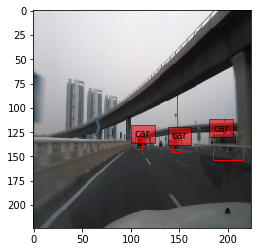

Ground Truth


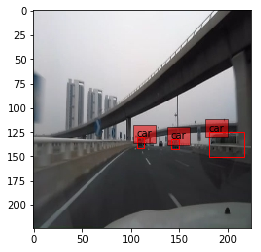

(7, 7, 9)
Prediction


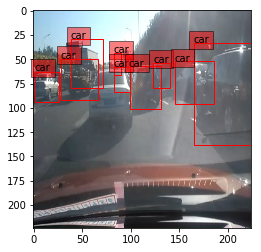

Ground Truth


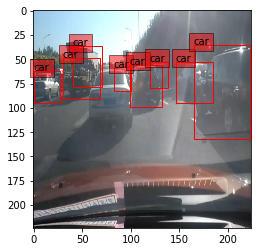

(7, 7, 9)
Prediction


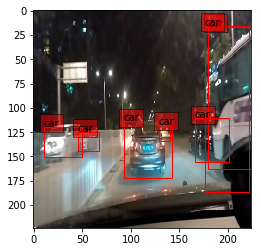

Ground Truth


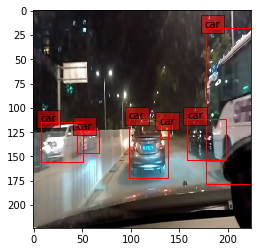

(7, 7, 9)
Prediction


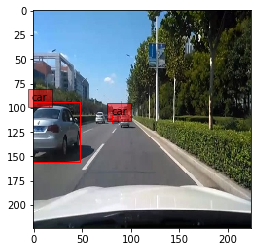

Ground Truth


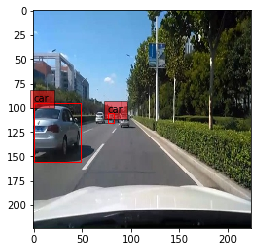

(7, 7, 9)
Prediction


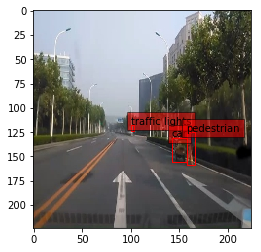

Ground Truth


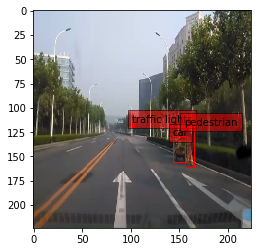

(7, 7, 9)
Prediction


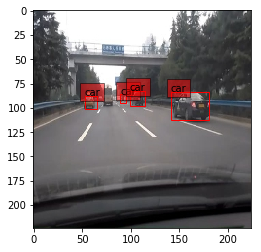

Ground Truth


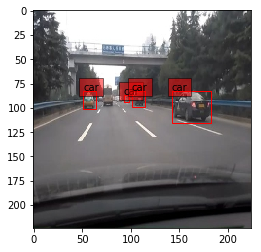

(7, 7, 9)
Prediction


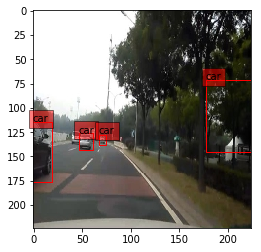

Ground Truth


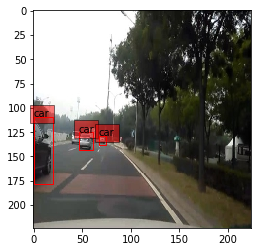

(7, 7, 9)
Prediction


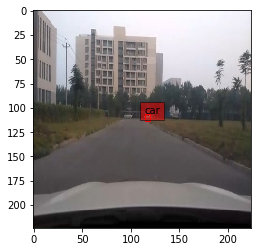

Ground Truth


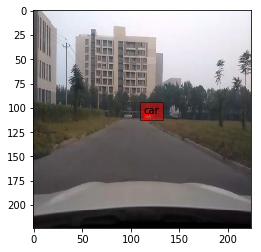

(7, 7, 9)
Prediction


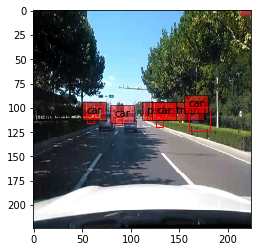

Ground Truth


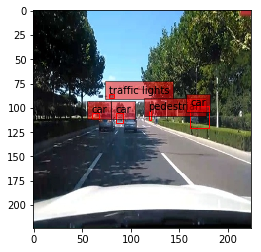

(7, 7, 9)
Prediction


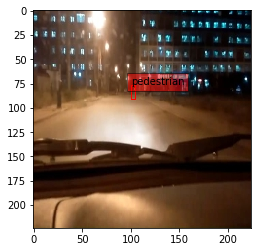

Ground Truth


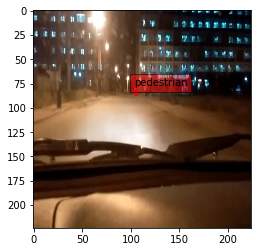

IndexError: index 10 is out of bounds for axis 0 with size 10

In [6]:
data.reset()
for i in range(10):
    batch = data.next()
    img = batch.data[0].asnumpy()[0].transpose((1,2,0))
    label = batch.label[0].asnumpy().reshape((7,7,9))
    pred = (out.asnumpy()[i]+1)/2
    print pred.shape
    print "Prediction"
    bboxdraw(img, pred)
    print "Ground Truth"
    bboxdraw(img, label)